In [13]:
# Packages
using BenchmarkTools
#
using CSV
using DifferentialEquations
#using DataInterpolations
#using DiffEqParamEstim
using Optim
using LinearAlgebra
using Plots; pyplot
#using Plots.PlotMeasures
using LaTeXStrings
#using NLsolve
;

In [14]:
LW1 = 2.5;

In [15]:
df=CSV.read("realdata.csv")
#load If, It, Twc
df_input = df[70:653, [:Column6, :Column13, :Column11 ]]
df_output = df[70:653, [:Column7, :Column8]]
df_water_temp = df[70:653, [:Column10, :Column9]]
If_s, It_s, Twc_s = df_input[1],df_input[2],df_input[3]
Ts_meas_s, TFe_meas_s = df_output[1], df_output[2]
Tac_s, Tah_s = df_water_temp[1],df_water_temp[2]
# All data are vectors of strings and missing, so converting
# it back to float64
#
# N measurement data are used
N = 584
If,It,Twc,Ts_m,TFe_m =zeros(N),zeros(N),zeros(N),zeros(N),zeros(N)
Tac_m, Tah_m = zeros(N), zeros(N)
for i in range(1,step=1,N)
    If[i]=parse(Float64, If_s[i])
    It[i]=parse(Float64, It_s[i])
    Twc[i]=parse(Float64, Twc_s[i])
    Ts_m[i]=parse(Float64, Ts_meas_s[i])
    TFe_m[i]=parse(Float64, TFe_meas_s[i])
    Tac_m[i]=parse(Float64, Tac_s[i])
    Tah_m[i]=parse(Float64, Tah_s[i])
end
tm = range(0,stop=(584-1));

In [16]:
# Available data of states for defining loss function
data = [Ts_m TFe_m]'

2×584 Adjoint{Float64,Array{Float64,2}}:
 31.4186  32.3701  32.9818  34.4092  …  68.8184  68.8184  68.8184  68.8184
 32.3701  32.3701  32.3701  32.3701     60.3393  60.3393  60.3393  60.3393

In [17]:
# Input functions given from data each at 60 sec
function If_t(t)
    # Iterative value of Ifd from real data
    # taken at 60 seconds
    t=trunc(Int,t/60+1)
    return If[t]
end
function It_t(t)
    # Iterative value of It from real data
    t=trunc(Int,t/60+1)
    return It[t]
end
function Twc_t(t)
    # Iterative value of Twc from real data
    t=trunc(Int,t/60+1)
    return Twc[t]
end
#
time = range(tm[1],tm[end],length=10^3)
@benchmark If_t.(time)

BenchmarkTools.Trial: 
  memory estimate:  31.56 KiB
  allocs estimate:  1496
  --------------
  minimum time:     54.303 μs (0.00% GC)
  median time:      56.419 μs (0.00% GC)
  mean time:        85.114 μs (4.00% GC)
  maximum time:     12.187 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [18]:
u = (If=If_t, It=It_t, Twc=Twc_t)

(If = If_t, It = It_t, Twc = Twc_t)

In [19]:
# Model 1
function generator(dx,x,p,t,u)
    # unpacking states
    Tr,Ts,TFe = x
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # inputs
    If = u.If(t)
    It = u.It(t)
    Twc = u.Twc(t)
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe = 1.012,4.1813,0.385,0.412 
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    # Matrices
    M1 = diagm(0=>[(Nmr*mr)*chpCu , (Nms*ms)*chpCu , (NmFe*mFe)*chpFe])
    M2 = [-(NUAr2d*UAr2d) 0. 0.; 0. -(NUAs2Fe*UAs2Fe) (NUAs2Fe*UAs2Fe); 0. (NUAs2Fe*UAs2Fe) -(NUAs2Fe*UAs2Fe)-(NUAFe2a*UAFe2a)]
    M3 = [0. (UAr2d) 0.; 0. 0. 0.; 0. 0. (UAFe2a)]
    #
    N1 = [-(Nmda*mda)*chpa (Nmda*mda)*chpa+(NUAr2d*UAr2d) 0.; 0. -(Nmda*mda)*chpa (Nmda*mda)*chpa+(NUAFe2a*UAFe2a); NStw-NSta*exp(-NStd) 0. -NStd]
    N2 = [(NUAr2d*UAr2d) 0. 0.; 0. 0. (NUAFe2a*UAFe2a); 0. 0. 0.]
    #
    v = [1.1*(NRr*Rr)*If^2, 3*(NRs*Rs)*It^2, (NQdFes*QdFes)]
    w = [Qdfs, 0., NSta*(1-exp(-NStd))*Twc]
    #
    z = N1\(N2*x + w)
    dxdt = M1\(M2*x+M3*z + v)
    dx[1],dx[2],dx[3]=dxdt
end
#
gen = (dx,x,p,t) -> generator(dx,x,p,t,u)
# Parameters
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
#p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
p = fill(1.,14)
# Initial values
x0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 583*60.)
# Defining ODE problem
prob = ODEProblem(gen,x0,tspan,p)
# @benchmark sol = solve(prob, ABM54(), dt=60)
@benchmark solve(prob, Tsit5(), saveat=60)

BenchmarkTools.Trial: 
  memory estimate:  2.17 MiB
  allocs estimate:  42838
  --------------
  minimum time:     1.712 ms (0.00% GC)
  median time:      2.799 ms (0.00% GC)
  mean time:        4.048 ms (15.03% GC)
  maximum time:     49.908 ms (53.17% GC)
  --------------
  samples:          1232
  evals/sample:     1

In [20]:
sol = solve(prob, Tsit5(), saveat=60)
Sol = reduce(hcat,sol.(sol.t));

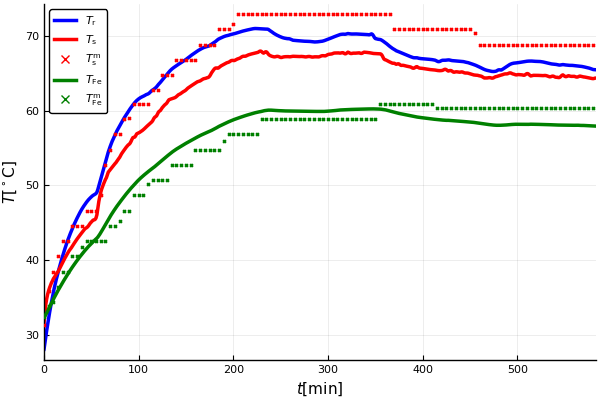

In [21]:
plot(sol.t/60,Sol[1,:],lw=LW1,lc=:blue,label=L"T_\mathrm{r}")
plot!(sol.t/60,Sol[2,:],lw=LW1,lc=:red,label=L"T_\mathrm{s}")
plot!(tm[1:5:end],Ts_m[1:5:end],m=:x,st=:scatter,ms=2,mc=:red,msc=:red,label=L"T_\mathrm{s}^\mathrm{m}")
plot!(sol.t/60,Sol[3,:],lw=LW1,lc=:green,label=L"T_\mathrm{Fe}")
plot!(tm[1:5:end],TFe_m[1:5:end],m=:x,st=:scatter,ms=2,mc=:green,msc=:green,label=L"T_\mathrm{Fe}^\mathrm{m}")
plot!(xlims=(tm[1],tm[end]))
plot!(xlabel=L"t [\mathrm{min}]",ylabel=L"T [{}^\circ \mathrm{C}]")

In [72]:
Data = vcat(Ts_m',TFe_m');
#
function cost(par,idx)
    p = fill(1.,14)
    tspan=(0,583*60.)
    p[idx] .= par
    gen = (dx,x,p,t) -> generator(dx,x,p,t,u)
    prob = ODEProblem(gen,x0,tspan,p)
    sol = solve(prob,Euler(),dt=30, saveat=60, save_idxs = [2,3])
    Sol = reduce(hcat,sol.(sol.t))
    return norm(Data .- Sol,2)./(584*2.0)
end

cost (generic function with 1 method)

In [73]:
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
#
using Plots.PlotMeasures
pyplot()
pp = range(0.2,2,length=50)
loss = (par) -> cost(par,[1])
labels = ["\$m_\\mathrm{r}^*\$","\$m_\\mathrm{s}^*\$","\$m_\\mathrm{Fe}^*\$",
    "\$R_\\mathrm{r}^*\$","\$R_\\mathrm{s}^*\$","\$\\mathcal{U}A^*_\\mathrm{r2\\delta}\$","\$\\mathcal{U}A^*_\\mathrm{s2Fe}\$",
    "\$\\mathcal{U}A^*_\\mathrm{Fe2a}\$","\$\\mathcal{h}A^*_\\mathrm{ax}\$","\$\\mathcal{h}A^*_\\mathrm{wx}\$",
    "\$\\dotQ^{\\sigma*}_\\mathrm{Fe}\$","\$\\dotW^*_\\mathrm{f}\$","\$\\dotm^*_\\mathrm{a}\$","\$\\dotm^*_\\mathrm{w}\$"]
fg = [plot(pp,loss.(pp),label=labels[1])]
for i in 2:14
    idx = [i]
    loss = (par) -> cost(par,idx)
    push!(fg,plot(pp,loss.(pp),label=labels[i]))
end

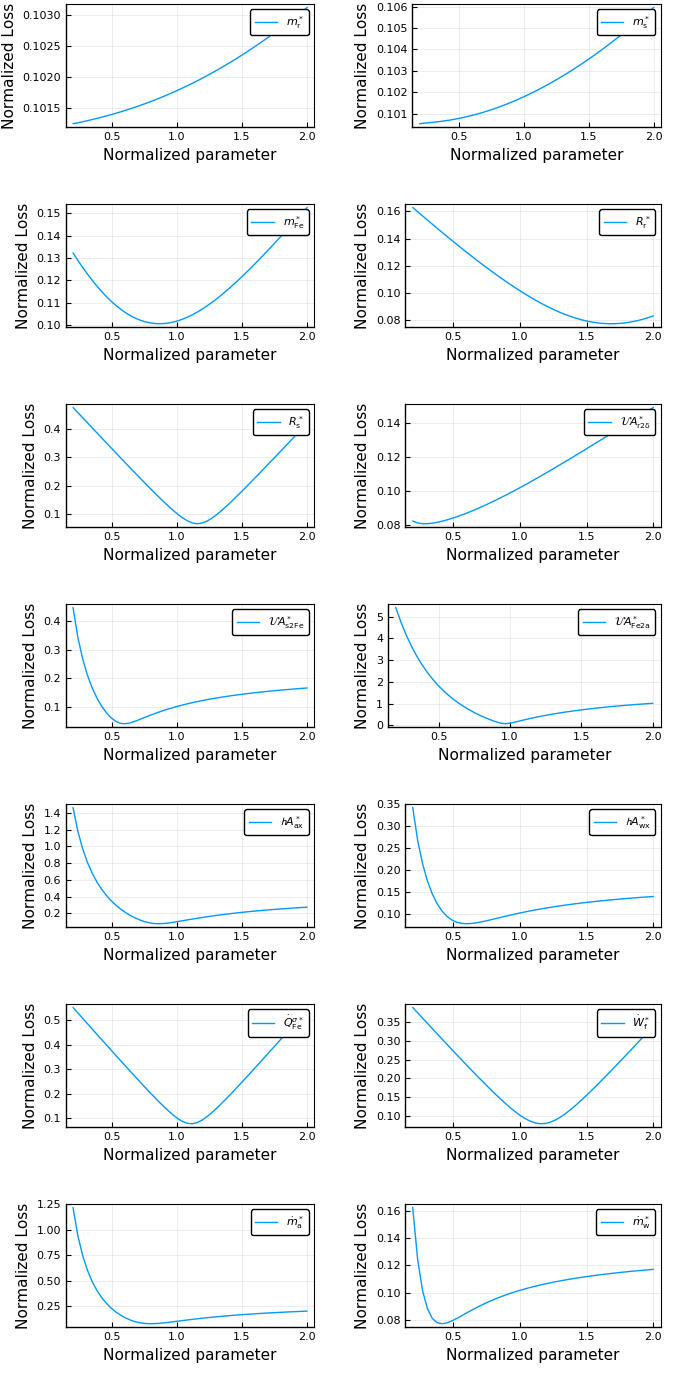

In [74]:
#fg = push!(fg,plot())

plot(fg...,layout=(7,2),size=(700,1400),framestyle=:box,ylabel="Normalized Loss",
    xlabel="Normalized parameter",legend=:topright,bottom_margin=10mm,right_margin=10mm)

In [15]:
loss = (par) -> cost(par,[12])
@benchmark optimizer = optimize(loss,[0.3],[2.],[1.0],Fminbox(GradientDescent())).minimizer

BenchmarkTools.Trial: 
  memory estimate:  992.24 MiB
  allocs estimate:  23961368
  --------------
  minimum time:     2.871 s (9.23% GC)
  median time:      2.998 s (9.03% GC)
  mean time:        2.998 s (9.03% GC)
  maximum time:     3.126 s (8.85% GC)
  --------------
  samples:          2
  evals/sample:     1

In [16]:
loss = (par) -> cost(par,[12])
@benchmark optimizer = optimize(loss,[0.3],[2.],[1.0],Fminbox()).minimizer

BenchmarkTools.Trial: 
  memory estimate:  574.52 MiB
  allocs estimate:  13855792
  --------------
  minimum time:     1.761 s (8.88% GC)
  median time:      1.881 s (9.19% GC)
  mean time:        1.862 s (9.13% GC)
  maximum time:     1.944 s (9.29% GC)
  --------------
  samples:          3
  evals/sample:     1

In [23]:
loss = (par) -> cost(par,[12,13])
optimizer = optimize(loss,[0.3,0.3],[2.,2.],[1.0,1.0],Fminbox(NelderMead)).minimizer

MethodError: MethodError: no method matching NelderMead(::GradientDescent{LineSearches.InitialPrevious{Float64},LineSearches.HagerZhang{Float64,Base.RefValue{Bool}},Nothing,getfield(Optim, Symbol("##12#14"))})
Closest candidates are:
  NelderMead(; kwargs...) at C:\Users\pande\.julia\packages\Optim\Agd3B\src\multivariate\solvers\zeroth_order\nelder_mead.jl:76
  NelderMead(!Matched::Ts<:Optim.Simplexer, !Matched::Tp<:Optim.NMParameters) where {Ts<:Simplexer, Tp<:NMParameters} at C:\Users\pande\.julia\packages\Optim\Agd3B\src\multivariate\solvers\zeroth_order\nelder_mead.jl:41

In [22]:
loss = (par) -> cost(par,[12,13])
optimizer = optimize(loss,[0.3,0.3],[2.,2.],[1.0,1.0],Fminbox(GradientDescent())).minimizer

2-element Array{Float64,1}:
 1.0911753700922682
 0.903226625651286 

In [173]:
# Optimizing parameter 7, i.e., in plot matrix element (3,1)
result = zeros(0)
for i in 1:14
    idx = [i]
    loss = (par) -> cost(par,idx)
    optimizer = optimize(loss,[0.3],[2.],[1.0],Fminbox(GradientDescent())).minimizer
    append!(result,optimizer)
end
result

14-element Array{Float64,1}:
 1.1736807753873675
 1.0133621651500735
 0.8537739174791855
 1.0               
 1.0               
 0.3078552398968299
 0.716775791695861 
 0.9621473877286544
 0.866292964725963 
 0.6078592476536769
 1.110129307914387 
 1.1632265687943621
 0.7965502138342192
 0.4622461182302797

In [174]:
# Comparing the result except mr,ms,Rr,Rs,UAr2d the result seems OK with gradiant descent.

In [175]:
loss = (par) -> cost(par,[8,9])
optimize(loss,[0.1,0.1],[1.5,1.5],[1.0,1.0],Fminbox(GradientDescent())).minimizer

2-element Array{Float64,1}:
 0.9725701930419024
 0.9704140860697913

In [19]:
loss = (par) -> cost(par,[1,2,3,4,5,6,7,8,9])
initial = [1]
lb = 0.1*initial
ub = 1.5*initial
optimize(loss,lb,ub,initial,NelderMead()).minimizer

InexactError: InexactError: Int64(Int64, NaN)